# Домашнее задание 1. Сбор данных

При решении реальных задач мы почти никогда не имеем дело с "хорошими" исходными данными, уже подготовленными для обработки и анализа. Как правило на входе имеются неструкткрированные данные в "грязном" виде, например необработанные тексты, изображения или аудио файлы. Иногда нет даже этого, и данные приходится собирать из разных доступных источников: разнообразных баз данных, внешних сервисов и даже электронных таблиц. После того, как данные получены, их унифицируют, очищают от шума, преобразовывают в нужный вид и сохраняют для дальнейшего анализа. В одном из традиционных подходов к [Data Mining](http://www.wikiwand.com/en/Online_analytical_processing) этот процесс называется Extract-Transform-Load ([ETL](http://www.wikiwand.com/en/Extract,_transform,_load)).

Цель этого задания собрать первые данные о пользователях из обучающей выборки и провести простейший качественный анализ. В ходе решения будут использованы:
1. [numpy](http://www.numpy.org/) -- библиотека для работы с многомерными массивами
2. [pandas](http://pandas.pydata.org/) -- библиотека, позволяющая удобно работать с различными типами данных
3. [requests](http://docs.python-requests.org/en/latest/) -- библиотека, которую можно использовать для вызова HTTP запросов
4. [python-twitter](https://github.com/bear/python-twitter/tree/master/twitter) -- обертка для Twitter API
5. [matplotlib](http://matplotlib.org/) -- библиотека для рисования графиков в python

Первым делом импортируем необходимые библиотеки и убеждаемся, что все установлено.

In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import mpl_toolkits.basemap as bm
import twitter
import requests
import datetime
import dateutil
import csv
import os
import json



# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Чтение исходных данных из файла

Считываем исходные данные из файла в data frame библиотеки pandas. Полученный data frame должен иметь целочисленный ключ и две колонки:
1. uid -- идентификатор пользователя
2. cat -- числовой номер класса

In [2]:
TRAINING_SET_URL = "twitter_train.txt"
EXAMPLE_SET_URL = "twitter_example.txt"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0, names=["uid", "cat"])
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0, names=["uid", "cat"])
df_users_ex['cat'] = None
df_users = pd.concat([df_users_train, df_users_ex])
df_users.head()

,uid,cat
0,40585382,1
1,30005269,0
2,3314758074,0
3,14311688,0
4,110457801,0


Построим распределение целевой переменной. Требуется получить [barchart](http://www.wikiwand.com/en/Bar_chart), в котором высота столбика, соответствующего каждому из классов, пропорциональна количеству пользователей этого класса. По горизонтальной оси отложены классы (positive, negative), а по вертикальной -- количество пользователей.

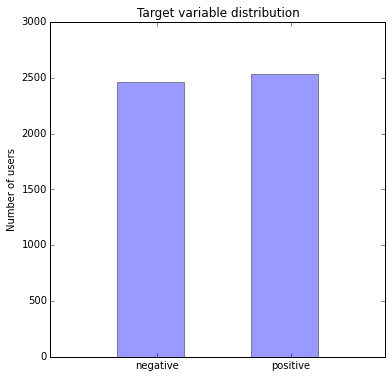

In [3]:
# Compute the distribution of the target variable
counts, bins = np.histogram(df_users_train["cat"], bins=[0,1,2])

# Plot the distribution
pl.figure(figsize=(6,6))
pl.bar(bins[:-1], counts, width=0.5, alpha=0.4)
pl.xticks(bins[:-1] + 0.3, ["negative", "positive"])
pl.xlim(bins[0] - 0.5, bins[-1])
pl.ylabel("Number of users")
pl.title("Target variable distribution")
pl.show()

In [4]:
df_users['cat'].value_counts()

1    2536
0    2464
dtype: int64

## Сбор данных

Для того чтобы разработать модель, которая предсказывает значение целевой переменной для произвольного пользователя, недостаточно знать только значения идентификаторов пользоватей. Причина в том, что _user_id_ для пользователя никак не зависит от целевой переменной -- идентификатор генерируется на основании времени регистрации, сервера, обрабатывающего запрос, и номера пользователя ([подробности](https://dev.twitter.com/overview/api/twitter-ids-json-and-snowflake)).

Поэтому нам потребуется загрузить дополнительную информацию о каждом пользователе, иначе говоря провести сбор данных (data collection). Наиболее важную информацию можно загрузить из [Twitter](https://dev.twitter.com/rest/public) [API](http://www.wikiwand.com/en/Representational_state_transfer). При желании можно воспользоваться и другими источниками -- об этом ниже.

Для того, чтобы получить доступ к API прежде всего необходимо зарегистрироваться в Twitter в качестве разработчика и создать свое [приложение](https://apps.twitter.com/). После создания приложения будет доступен набор ключей, которые мы будем использовать для аутентификации. Эти ключи необходимо скопировать в соответствующие константы ниже. Подробнее о том, как работает аутентификация в Twitter API можно почитать [по ссылке](https://dev.twitter.com/oauth/application-only), хотя это нужно скорее для ознакомления: библиотека обращения с API позаботится о механизме аутентификации за нас.

In [5]:
CONSUMER_KEY = "***"
CONSUMER_SECRET = "***"

ACCESS_TOKEN_KEY = "***"
ACCESS_TOKEN_SECRET = "***"


api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)

Twitter API предоставляет информацию о местонахождении пользователя, но эта информация представлена в текстовом виде, например так:
```
"location": "San Francisco, CA"
```
Такие текстовый описания не слишком удобны для анализа, поэтому наша цель -- получить более структурированную информацию, такую как географические координаты, страна, город и т.д. Для этого удобно использовать геоинформационный сервис, например [GeoNames](http://www.geonames.org/export/web-services.html). Для его использования также необходимо зарегистрироваться, подтвердить регистрацию и включить поддержку API. После этого можно будет посылать запросы для нахождения нужной информации. Например на запрос
```
http://api.geonames.org/search?q="San Francisco, CA"&maxRows=10&username=demo
```
возвращается результат,
```javascript
{
    "totalResultsCount": 2112,
    "geonames": [
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "city, village,...",
            "countryCode": "US",
            "lng": "-122.41942",
            "fcodeName": "seat of a second-order administrative division",
            "toponymName": "San Francisco",
            "fcl": "P",
            "name": "San Francisco",
            "fcode": "PPLA2",
            "geonameId": 5391959,
            "lat": "37.77493",
            "adminName1": "California",
            "population": 805235
        },
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "spot, building, farm",
            "countryCode": "US",
            "lng": "-122.3758",
            "fcodeName": "airport",
            "toponymName": "San Francisco International Airport",
            "fcl": "S",
            "name": "San Francisco International Airport",
            "fcode": "AIRP",
            "geonameId": 5391989,
            "lat": "37.61882",
            "adminName1": "California",
            "population": 0
        }
    ]
}
```
из которого легко извлечь нужную информацию.

**Замечание: для запросов необходимо использовать своего пользователя, кроме того количество запросов ограничего 30к в день**.

Первым делом нам понадобится функция, которая возвращает информацию о местоположении для данного текстового запроса. Требуется реализовать функцию get_coordinates_by_location, принимающую на вход строку с местоположением и возвращает кортеж вида (долгота, широта, город).

In [9]:
GEO_USER_NAME = "***"
Locations = {}

def get_coordinates_by_location(location):  
    if location in Locations:
        return Locations[location]
    else:
        r = requests.get('http://api.geonames.org/searchJSON?q="'+location+'"&maxRows=1&username='+GEO_USER_NAME)
        r = json.loads(r.text)  
    
        if 'geonames' not in r:
            Locations[location] = (None, None, None)
            return (None, None, None)
    
        if len(r['geonames'])!=0:
            geo_names = r['geonames'][0]
            if 'countryName' in geo_names and geo_names['countryName']!='NaN':
                country = geo_names['countryName']
            else:
                country = None
            if 'lat' in geo_names and geo_names['lat']!=NaN:
                lat = float(geo_names['lat'])
            else:
                lat = None
            if 'lng' in geo_names and geo_names['lng']!=NaN:
                lng = float(geo_names['lng']) 
            else:
                lng = None
            Locations[location] = (lat, lng, country)
            return (lat, lng, country)
        else:
            Locations[location] = (None, None, None)
            return (None, None, None)

In [10]:
get_coordinates_by_location('электросталь')

(55.78959, 38.44671, u'Russia')

Следующий шаг -- вызов Twitter API для сбора данных и сохранения их в data frame. После чего data frame c собранными данными совмещается с data frame, содержащим данные исходной обучающей выборки. 

В этой части задания нужно реализовать функцию `get_user_records`, которая принимает на вход прочитанный из файла `data frame` и возвращает список словарей, каждый из которых представляет данные одного пользователя. Для того, чтобы получить из объекта класса [`User`](https://github.com/bear/python-twitter/blob/master/twitter/user.py) словарь в правильном формате, нужно использовать функцию `twitter_user_to_dataframe_record` (4 балла).

Так как скрипт работает существенное время, будем сохранять промежуточный результат.

In [11]:
user_records = []
tmp_file_name = 'tmp_user_records'
if os.path.exists(tmp_file_name):
    with open(tmp_file_name) as f:
        for line in f:
            try:
                user_records.append(json.loads(line))
            except:
                continue

processed_users = set()
for r in user_records:
    processed_users.add(r['uid'])
    


In [27]:
ts_parser = lambda date_str: dateutil.parser.parse(date_str) if pd.notnull(date_str) else None
f = open(tmp_file_name, 'a')
            

request_count= 0
def twitter_user_to_dataframe_record(user):
    global request_count
    dt = ts_parser(user.created_at)
    record = {
        "uid": user.id,
        "name": user.name,
        "screen_name": user.screen_name,        
        "created_at": dt.strftime("%Y-%m") if dt else dt,        
        "followers_count": user.followers_count,
        "friends_count": user.friends_count,
        "statuses_count": user.statuses_count,
        "favourites_count": user.favourites_count,
        "listed_count": user.listed_count,
        "verified": user.verified
    }
    
    if user.description is not None and user.description.strip() != "":
        record["description"] = user.description
        
    if user.location is not None and user.location.strip() != "":
        request_count = request_count + 1
        record["location"] = user.location
        record["lat"], record["lon"], record["country"] = get_coordinates_by_location(user.location)
    
    return record


def get_user_records(df):
    users_list = []
    user_pack = range(0,len(df),100)
    if len(df)!=user_pack[-1]:
        user_pack.append(len(df))
 
    for n in range(len(user_pack[:-1])):
        print(user_pack[n+1])
        u_id = df['uid'].values[user_pack[n]:user_pack[n+1]].tolist()
        users = api.UsersLookup(user_id=u_id)
        
        for user in users:
            record = twitter_user_to_dataframe_record(user)
            users_list.append(record)
            f.write(json.dumps(record))
            f.write('\n')
            
        
    return(users_list)
    # your code here
    # some_downloaded_user = get_user_from_api
    # also write user as json line in temporary file
    # return [twitter_user_to_dataframe_record(some_downloaded_user)]

# Maximum number of user IDs returned by Twitter's user lookup

user_records = get_user_records(df_users)

        
print "Creating data frame from loaded data"
df_records = pd.DataFrame(user_records, columns=["uid", "name", "screen_name", "description", "verified", "location", "lat", "lon", "country", "created_at", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"])
print "Merging data frame with the training set"
df_full = pd.merge(df_users, df_records, on="uid", how="left")
print "Finished building data frame"

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6898
Creating data frame from loaded data
Merging data frame with the training set
Finished building data frame


In [38]:
len(df_full[df_full["country"].isnull() == True])

3257

In [39]:
f.close()
df_full.head(5)

,uid,cat,name,screen_name,description,verified,location,lat,lon,country,created_at,followers_count,friends_count,statuses_count,favourites_count,listed_count
0,40585382,1,Reverend Sue,ReverendSue,Retired Interfaith Minister. Activist. Equalit...,False,United States,39.76000,-98.50000,United States,2009-05,7614,4283,50620,787,417
1,30005269,0,Ryan Wrasse,RWrasse,Communications Director for @SenJohnThune | Ge...,False,Capitol Hill,15.20825,145.75313,Northern Mariana Islands,2009-04,1913,1240,7139,127,96
2,3314758074,0,Campaign Trump,Campaign_Trump,#Trump for President. Indp. Local & Internatio...,False,"Houston, TX",29.76328,-95.36327,United States,2015-08,18834,12618,1105,7105,164
3,14311688,0,Bernard Whitman,BernardWhitman,"Democratic strategist, pollster, and corporate...",False,New York,40.71427,-74.00597,United States,2008-04,1757,1292,7337,157,110
4,110457801,0,Carson Ingle,caingle,Writer for @AthleteSpeakers & @NOPACTalent. 10...,False,Orlando aka The City Beautiful,NaN,NaN,None,2010-02,1468,1188,37127,3311,79


## Exploratory Data Analysis

Для того, чтобы лучше понять, как устроена наша обучающая выборка, построим несколько графиков. Сначала построим долю "положительных" пользователей в зависимости от дня создания аккаунта. По горизонтальной оси отложим день создания аккаунта, а по вертикальной -- долю "положительных" пользователей ([подсказка](http://anokhin.github.io/img/hw1_distr.png)). Необходимо дописать код функции count_users. В функции необходимо посчитать пользователей в каждой группе (2 балла).

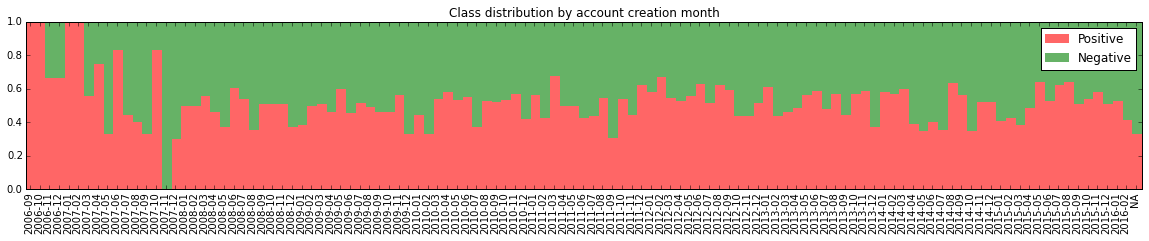

In [40]:
def count_users(grouped):
    
    """
    Counts number of positive and negative users
    created at each date.
    
    Returns:
        count_pos -- 1D numpy array with the counts of positive users created at each date
        count_neg -- 1D numpy array with the counts of negative users created at each date
        dts -- a list of date strings, e.g. ['2014-10', '2014-11', ...]
    """
    dts = grouped.groups.keys()
    count_pos, count_neg = np.zeros(len(grouped)), np.zeros(len(grouped))
    
    
    for i in range(len(grouped)):
        date_group = grouped.get_group(dts[i])
        count_pos[i] = len(date_group[date_group['cat']==1])
        count_neg[i] = len(date_group[date_group['cat']==0])
    
    return count_pos, count_neg, dts


grouped = df_full.groupby(map(lambda dt: dt if pd.notnull(dt) else "NA", df_full["created_at"]))
count_pos, count_neg, dts = count_users(grouped)
    
fraction_pos = count_pos / (count_pos + count_neg + 1e-10)
fraction_neg = 1 - fraction_pos

sort_ind = np.argsort(dts)
    
pl.figure(figsize=(20, 3))
pl.bar(np.arange(len(dts)), fraction_pos[sort_ind], width=1.0, color='red', alpha=0.6, linewidth=0, label="Positive")
pl.bar(np.arange(len(dts)), fraction_neg[sort_ind], bottom=fraction_pos[sort_ind], width=1.0, color='green', alpha=0.6, linewidth=0, label="Negative")
pl.xticks(np.arange(len(dts)) + 0.4, sorted(dts), rotation=90)
pl.title("Class distribution by account creation month")
pl.xlim(0, len(dts))
pl.legend()
pl.show()

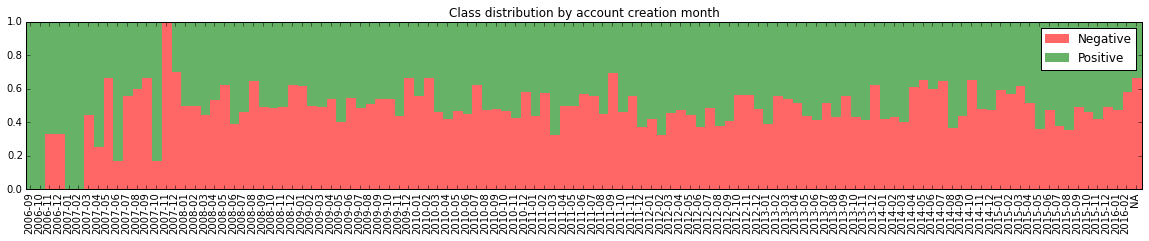

In [41]:
def count_users(grouped):
    
    """
    Counts number of positive and negative users
    created at each date.
    
    Returns:
        count_pos -- 1D numpy array with the counts of positive users created at each date
        count_neg -- 1D numpy array with the counts of negative users created at each date
        dts -- a list of date strings, e.g. ['2014-10', '2014-11', ...]
    """
    dts = grouped.groups.keys()
    count_pos, count_neg = np.zeros(len(grouped)), np.zeros(len(grouped))
    
    
    for i in range(len(grouped)):
        date_group = grouped.get_group(dts[i])
        count_pos[i] = len(date_group[date_group['cat']==0])
        count_neg[i] = len(date_group[date_group['cat']==1])
    
    return count_pos, count_neg, dts


grouped = df_full.groupby(map(lambda dt: dt if pd.notnull(dt) else "NA", df_full["created_at"]))
count_pos, count_neg, dts = count_users(grouped)
    
fraction_pos = count_pos / (count_pos + count_neg + 1e-10)
fraction_neg = 1 - fraction_pos

sort_ind = np.argsort(dts)
    
pl.figure(figsize=(20, 3))
pl.bar(np.arange(len(dts)), fraction_pos[sort_ind], width=1.0, color='red', alpha=0.6, linewidth=0, label="Negative")
pl.bar(np.arange(len(dts)), fraction_neg[sort_ind], bottom=fraction_pos[sort_ind], width=1.0, color='green', alpha=0.6, linewidth=0, label="Positive")
pl.xticks(np.arange(len(dts)) + 0.4, sorted(dts), rotation=90)
pl.title("Class distribution by account creation month")
pl.xlim(0, len(dts))
pl.legend()
pl.show()

Картинка как в исходном тексте задания получается, если поменять местами neg и pos. Ведь cat = 1 это положительный класс, исходя из предшествующей части задания.
Или я что-то не так делаю... 

Видно, что доля "положительных" аккаунтов в выборке растет с увеличением времени. Посмотрим, где живут пользователи положительной и отрицательной категории. Для этого отметим на карте каждого положительного пользователя красным, а отрицательного -- зеленым цветом ([подсказка](http://anokhin.github.io/img/hw1_map.png)). Необходимо реализовать функцию plot_points_on_map. В функции необходимо отобразить на карте пользователей из разных классов (2 балла).

C:\Users\1-ion\Anaconda\lib\site-packages\IPython\kernel\__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\1-ion\Anaconda\lib\site-packages\IPython\kernel\__main__.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


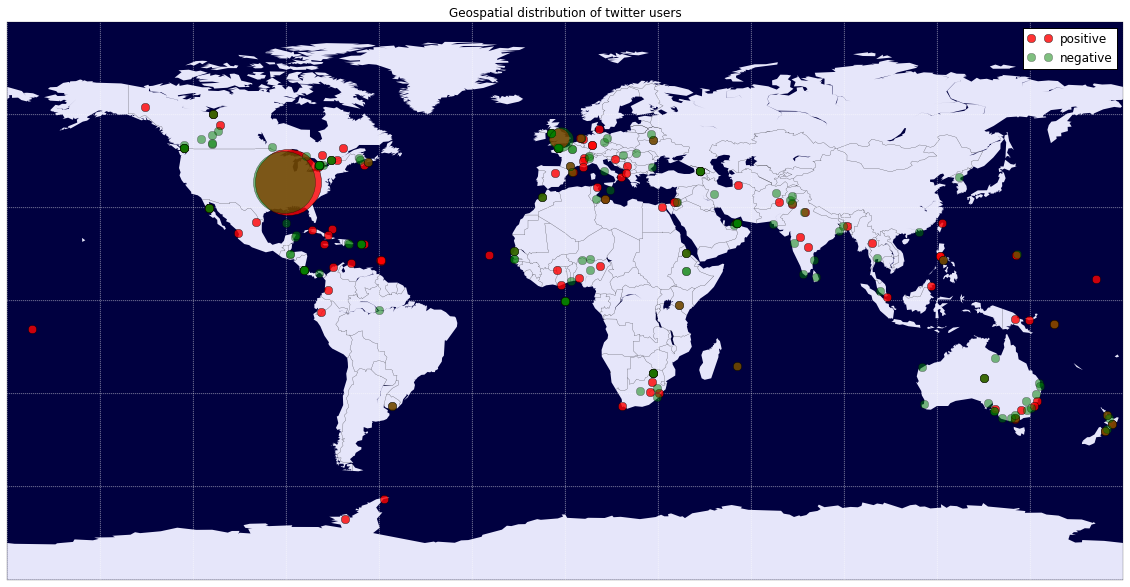

In [42]:


pl.figure(figsize=(20,12))

m = bm.Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')

m.drawcountries(linewidth=0.2)
m.fillcontinents(color='lavender', lake_color='#000040')
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)



def plot_points_on_map(df_full):
    """
    Plot points on the map. Be creative.
    """
    grouped = df_full.groupby('cat') 
    group1 = grouped.get_group(1).dropna(subset=['lat'])
    group2 = grouped.get_group(0).dropna(subset=['lat'])
    
    group1_us = group1[group1['country']=='United States']
    group1_uk = group1[(group1['country']=='United Kingdom') | (group1['country']=='Ireland')]
    group1_other = group1[(group1['country']!='United States') & (group1['country']!='United Kingdom') & (group1['country']!='Ireland')]
    group1_us = group1_us[['lon','lat','country']].groupby('country').agg(['mean', 'count'])
    group1_uk['country']= 'UK'
    group1_uk = group1_uk[['lon','lat','country']].groupby('country').agg(['mean', 'count'])
    
    group2_us = group2[group2['country']=='United States']
    group2_uk = group2[(group2['country']=='United Kingdom') | (group2['country']=='Ireland')]
    group2_other = group2[(group2['country']!='United States') & (group2['country']!='United Kingdom') & (group2['country']!='Ireland')]
    group2_us = group2_us[['lon','lat','country']].groupby('country').agg(['mean', 'count'])
    group2_uk['country']= 'UK'
    group2_uk = group2_uk[['lon','lat','country']].groupby('country').agg(['mean', 'count'])
    
                     
    x1_1, y1_1 = m(group1_other['lon'].values, group1_other['lat'])
    x1_2, y1_2 = m(group1_us.values[:,0], group1_us.values[:,2])
    x1_3, y1_3 = m(group1_uk.values[:,0], group1_uk.values[:,2])
    
    x2_1, y2_1 = m(group2_other['lon'].values, group2_other['lat'])
    x2_2, y2_2 = m(group2_us.values[:,0], group2_us.values[:,2])
    x2_3, y2_3 = m(group2_uk.values[:,0], group2_uk.values[:,2])
    

    markersize = 8
    markersize_us1 = group1_us.values[:,1][0]/20
    markersize_uk1 = group1_uk.values[:,1][0]/2
    
    markersize_us2 = group2_us.values[:,1][0]/20
    markersize_uk2 = group2_uk.values[:,1][0]/2
    
    m.plot(x1_1, y1_1, 'ro', markersize=markersize, label='positive', alpha=0.8)
    m.plot(x1_2, y1_2, 'ro', markersize=markersize_us1, alpha=0.8)
    m.plot(x1_3, y1_3, 'ro', markersize=markersize_uk1, alpha=0.8)
    
    m.plot(x2_1, y2_1, 'go', markersize=markersize, label='negative', alpha=0.5)
    m.plot(x2_2, y2_2, 'go', markersize=markersize_us2, alpha=0.5)
    m.plot(x2_3, y2_3, 'go', markersize=markersize_uk2, alpha=0.5)
    
    
    
    #m.plot(x2, y2, 'go', markersize=markersize, label='negative', alpha=0.5)
    return

plot_points_on_map(df_full)

pl.title("Geospatial distribution of twitter users")
pl.legend()
pl.show()

В последней картинке есть проблема: сервис геоинформации определяет координаты с точностью до города, поэтому точки, соответствующте нескольким пользователям, могут накладываться. Предложите и реализуйте способ, позволяющий справиться с этой проблемой (2 балла).

Смотрим на полученный data frame и сохраняем его в .csv файл.

В поле ниже необходимо словами описать, как было улучшено изображение (описание необходимо для корректной проверки задания).

На изображении сделаны следующие улучшения:
* В странах с очень большим числом пользователей они объединены в круги большего размера
* Настройка прозрачности позволяет проще отличить круги друг от друга

In [44]:
OUT_FILE_PATH = "hw1_out.csv"
print "Saving output data frame to %s" % OUT_FILE_PATH
df_full.to_csv(OUT_FILE_PATH, sep="\t", index=False, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)
df_full.head()

Saving output data frame to hw1_out.csv


,uid,cat,name,screen_name,description,verified,location,lat,lon,country,created_at,followers_count,friends_count,statuses_count,favourites_count,listed_count
0,40585382,1,Reverend Sue,ReverendSue,Retired Interfaith Minister. Activist. Equalit...,False,United States,39.76000,-98.50000,United States,2009-05,7614,4283,50620,787,417
1,30005269,0,Ryan Wrasse,RWrasse,Communications Director for @SenJohnThune | Ge...,False,Capitol Hill,15.20825,145.75313,Northern Mariana Islands,2009-04,1913,1240,7139,127,96
2,3314758074,0,Campaign Trump,Campaign_Trump,#Trump for President. Indp. Local & Internatio...,False,"Houston, TX",29.76328,-95.36327,United States,2015-08,18834,12618,1105,7105,164
3,14311688,0,Bernard Whitman,BernardWhitman,"Democratic strategist, pollster, and corporate...",False,New York,40.71427,-74.00597,United States,2008-04,1757,1292,7337,157,110
4,110457801,0,Carson Ingle,caingle,Writer for @AthleteSpeakers & @NOPACTalent. 10...,False,Orlando aka The City Beautiful,NaN,NaN,None,2010-02,1468,1188,37127,3311,79
